# Import

In [ ]:
print("start")

start


In [ ]:
# !pip install pytorch_lightning
!pip install lovely-tensors lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.7 MB/s eta 0:00:00


In [ ]:
"""
This cell is to allow importing python files that are manually downloaded bt me (maybe from GitHub)
"""


import sys
from pathlib import Path

# Add the path to the module to the Python path
module_path = "/kaggle/input/mobilefacenet-checkpoint/pytorch/default/3"
sys.path.append(module_path)

In [ ]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import os
from PIL import Image
import pickle
import pytorch_lightning as pl
import timm
import wandb
from pytorch_lightning.loggers import WandbLogger
from datetime import datetime
from model_MobileFaceNet import MobileFacenet
import lpips
import itertools
import lovely_tensors as lt
lt.monkey_patch()


device = "cuda" if torch.cuda.is_available() else "cpu"

# Task: Human face to anime

## Download Human face Data

In [ ]:

data_path = "/kaggle/input/ffhq-128-70k"
# data_path = '/content/1/Humans'

## Build dataset class

In [ ]:
from logging import setLogRecordFactory

class FlatImageDataset(Dataset):
    def __init__(self, paths=[], transform=None):
        self.paths = paths
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.transform(img) if self.transform else img


    @staticmethod
    def init_datasets(root="/kaggle/input/ffhq-128-70k", train_ratio = 0.7, train_transform=None, val_transform=None):
        paths = [os.path.join(root, f) for f in os.listdir(root)]
        train_paths, val_paths = random_split(paths, [train_ratio, 1-train_ratio])
        return FlatImageDataset(paths=train_paths, transform=train_transform), FlatImageDataset(paths=val_paths, transform=val_transform)




# Integrate pretrained models

## Build AE Model class

### Blocks classes

In [ ]:
class InvertedBottlenecBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion=2):
        super().__init__()
        # Calculate the hidden dimension based on the expansion factor
        hidden_dim = in_channels * expansion

        # If output channels are smaller, adjust the architecture accordingly
        self.block = nn.Sequential(
            # First pointwise convolution (expanding to hidden_dim)
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, padding="same"),
            nn.ReLU(inplace=True),

            # Depthwise separable convolution (staying at hidden_dim)
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, groups=hidden_dim, padding="same"),
            nn.ReLU(inplace=True),


            # reducing channels to in channels for non aggressive reduction
            nn.Conv2d(hidden_dim, in_channels, kernel_size=1, padding="same"),
            nn.ReLU(inplace=True),


            # Final pointwise convolution (contracting to out_channels)
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding="same"),
            # nn.ReLU(inplace=True) # remove this relu because in the decoder there is activation layer after each block
        )

    def forward(self, x):
        return self.block(x)

    def __str__(self):
        return "InvertedBottlenecBlock"




class SimpleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion=6):
        super().__init__()
        # Calculate the hidden dimension based on the expansion factor
        hidden_dim = in_channels * expansion

        # If output channels are smaller, adjust the architecture accordingly
        self.block = nn.Sequential(
            # First pointwise convolution (expanding to hidden_dim)
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same")

            # nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


    def __str__(self):
            return "simpleBlock"


class InceptionBlock(nn.Module):
    def __init__(self, in_channels, f1, f3_r, f3, f5_r, f5, f_pool):
        """
        Args:
            in_channels: Number of input channels.
            f1: Number of filters in 1x1 conv branch.
            f3_r: Number of filters in 1x1 conv before 3x3 conv.
            f3: Number of filters in 3x3 conv.
            f5_r: Number of filters in 1x1 conv before 5x5 conv.
            f5: Number of filters in 5x5 conv.
            f_pool: Number of filters in the pooling branch.
        """
        super(InceptionBlock, self).__init__()

        # 1x1 conv branch
        self.branch1 = nn.Conv2d(in_channels, f1, kernel_size=1, stride=1, padding=0)

        # 1x1 -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, f3_r, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(f3_r, f3, kernel_size=3, stride=1, padding=1)
        )

        # 1x1 -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, f5_r, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(f5_r, f5, kernel_size=5, stride=1, padding=2)
        )

        # Pooling branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, f_pool, kernel_size=1, stride=1, padding=0)
        )

        self.relu = nn.ReLU()

    def forward(self, x):
        b1 = self.relu(self.branch1(x))
        b2 = self.relu(self.branch2(x))
        b3 = self.relu(self.branch3(x))
        b4 = self.relu(self.branch4(x))

        # Concatenate along channel dimension
        return torch.cat([b1, b2, b3, b4], dim=1)



    def __str__(self):
        return "Inception"

class NormalizeForTanh(nn.Module):
    def forward(self, x):
        return x * 2 - 1 # normalize values from [0,1] into [-1,1]


### AutoEncoder classes

In [ ]:
class DynamicRegnet_Decoder(nn.Module): # BL = Bottle Neck
    def __init__(self, convs=[3, 40, 140, 240, 350, 440], act_fn = nn.ReLU(), out_act=nn.Tanh(), convBlock= None):
        super().__init__()
        # act_fn = nn.ReLU()
        self.layers = nn.Sequential()
        self.layers.append(nn.BatchNorm2d(convs[-1]))


        for i in range(len(convs)-1, 0, -1):
            # print(convs[i])
            self.layers.append(
                    nn.ConvTranspose2d(convs[i], convs[i], kernel_size=3, stride=2, padding=1, output_padding=1))

            self.layers.append(act_fn)

            self.layers.append(convBlock(convs[i], convs[i - 1]))

            if i > 1:
              self.layers.append(act_fn)
              # self.layers.append(nn.BatchNorm2d(convs[i - 1]))

        # output handling for testing multiple output activation functtions
        self.out_act = out_act
        self.input_normalize = nn.Identity()
        # if type(self.out_act) == type(nn.Tanh()):
        #     self.input_normalize = NormalizeForTanh()




    def forward(self, x):
        # x = self.input_normalize(x)
        # print(12,x)
        x = self.layers(x)
        # x = self.reduce128(x)
        x = self.out_act(x)

        # x.add_(1).div_(2) # doing (x = (x+1)/2) in-place -> faster and more memory efficient
        # x = (x+1)/2

        return x


class Inception_Decoder(nn.Module): # BL = Bottle Neck
    def __init__(self, convs=[3, 12, 20, 24, 28, 32], act_fn = nn.ReLU(), out_act=nn.Tanh(), convBlock= None):
        super().__init__()
        # act_fn = nn.ReLU()
        self.layers = nn.Sequential()
        self.layers.append(nn.BatchNorm2d(convs[-1][0]))
        for i in range(len(convs)-1, 0, -1):
            in_channels = convs[i][0]
            out_channels = convs[i-1][0]

            filters = convs[i][1]



            # print(convs[i])
            self.layers.append(
                    nn.ConvTranspose2d(in_channels, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1))

            self.layers.append(act_fn)

            if i == 1:
                self.layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            # self.layers.append(convBlock(in_channels, out_channels))
            else:
                self.layers.append(
                        InceptionBlock(in_channels, filters["f1"], filters['f3_r'], filters["f3"], filters["f5_r"], filters["f5"], filters["f_pool"]))

            # if i > 1:
                self.layers.append(act_fn)

          # self.layers.append(nn.BatchNorm2d(convs[i - 1]))




        # output handling for testing multiple output activation functtions
        self.out_act = out_act
        self.input_normalize = nn.Identity()
        # if type(self.out_act) == type(nn.Tanh()):
        #     self.input_normalize = NormalizeForTanh()


# InceptionBlock(nn.Module):
#     def __init__(self, in_channels, f1, f3_r, f3, f5_r, f5, f_pool)

    def forward(self, x):
        # x = self.input_normalize(x)
        # print(12,x)
        x = self.layers(x)
        # x = self.reduce128(x)
        x = self.out_act(x)

        # x.add_(1).div_(2) # doing (x = (x+1)/2) in-place -> faster and more memory efficient
        # x = (x+1)/2

        return x


class DynamicRegnet_AE(pl.LightningModule):
    def __init__(self, convs=[3, 40, 140, 240, 350, 440], loss_fn=nn.MSELoss(), learning_rate=0.001, trans=None, regnet_version = "regnety_004.pycls_in1k", out_act=nn.Identity(),convBlock= None, state_dict_params=None):
        super().__init__()

        if trans is None:
            trans = transforms.Compose([
                transforms.Resize((128, 128)),  # Resize first (order matters)
                transforms.ToTensor(),  # Convert to tensor
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        self.encoder = timm.create_model(regnet_version, pretrained=True)

        convs = [
            (3, None),
            (40, {"f1": 3, "f3_r": 1, "f3": 3, "f5_r": 1, "f5": 5, "f_pool": 3}),
            (140, {"f1": 10, "f3_r": 1, "f3": 15, "f5_r": 1, "f5": 10, "f_pool": 5}),
            (240, {"f1": 35, "f3_r": 1, "f3": 45, "f5_r": 1, "f5": 35, "f_pool": 25}),
            (350, {"f1": 60, "f3_r": 1, "f3": 80, "f5_r": 1, "f5": 60, "f_pool": 40}),
            (440, {"f1": 70, "f3_r": 1, "f3": 130, "f5_r": 1, "f5": 80, "f_pool": 70})
        ]
        # Inception_Decoder
        # self.decoder = DynamicRegnet_Decoder(convs, out_act=out_act, convBlock=convBlock)
        self.decoder = Inception_Decoder(convs, out_act=out_act, convBlock=convBlock)
        # self.loss_fn_vgg = lpips.LPIPS(net='vgg')

        # self.loss_fn = loss_fn
        self.learning_rate = learning_rate


        self.input_normalize = nn.Identity()
        if type(out_act) == type(nn.Tanh()):
            self.input_normalize = NormalizeForTanh()

        # load parameters before defining LPIPS cuz state dict params doesnt contain VGGG params
        if state_dict_params is not None:
            self.load_state_dict(state_dict_params)

        # self.loss_fn_vgg = lpips.LPIPS(net='alex')
        # Paths for reconstruction logging
        self.reconstruction_files = [
            "/kaggle/input/ffhq-128-70k/1.png",
            "/kaggle/input/ffhq-128-70k/10004.png",
            "/kaggle/input/ffhq-128-70k/10010.png",
            "/kaggle/input/ffhq-128-70k/10012.png"
        ]
        transform=trans
        self.reconstruction_images = [
            transform(Image.open(img).convert('RGB')).unsqueeze(0) for img in self.reconstruction_files
        ]


    def loss_fn(self, recon, true):
        # true = self.input_normalize(true)
        # lpips_loss = torch.abs(self.loss_fn_vgg(true, recon)).mean()
        # print(22,recon, true)
        mse_loss = F.mse_loss(recon, true)
        return mse_loss, 1, mse_loss
        total_loss = mse_loss + 0.1 * lpips_loss

        return total_loss, lpips_loss, mse_loss


    def forward(self, x):
        # x = self.input_normalize(x)
        features = self.encoder.forward_features(x)


        # features = features.view(x.shape[0], int(self.ae_latent/16), 4, 4) # do self.ae_latent/16 becase the spatial dims of the latent are 4*4
        # features = self.channel_reduction(features)
        recon = self.decoder(features)
        return recon

    def training_step(self, batch, batch_idx):
        data = batch.to(self.device).float()
        x_recon = self(data)
        loss, lpips_loss, mse_loss = self.loss_fn(x_recon, data)

        # Log training loss
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_mse_loss", mse_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_lpips_loss", lpips_loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data = batch.to(self.device).float()
        x_recon = self(data)
        loss, lpips_loss, mse_loss = self.loss_fn(x_recon, data)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_mse_loss", mse_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_lpips_loss", lpips_loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def on_train_epoch_end (self):
        # Call log_reconstructions every 20 epochs
        # if (self.current_epoch + 1) % 1 == 0:  # +1 because current_epoch is zero-indexed
        self.log_reconstructions()



    def log_reconstructions(self):
        self.eval()
        with torch.no_grad():
            logs = {}
            reconstructions = []
            for idx, img_tensor in enumerate(self.reconstruction_images):
                img_tensor = img_tensor.to(self.device)
                reconstructed = self(img_tensor).cpu()[0]
                reconstructed = self.unnormalize(reconstructed)

                rec_np = (reconstructed * 255).clamp(0, 255).byte().numpy().transpose(1, 2, 0).astype(np.uint8)

                logs[f"recon_{idx}"] = wandb.Image(rec_np, caption=f"Epoch {self.current_epoch}")

                filename = f"recon_epoch_{self.current_epoch}_idx{idx}.png"
                rec_img = Image.fromarray(rec_np)
                rec_img.save(filename)


            if self.logger is not None:
                self.logger.experiment.log(logs)


    def unnormalize(self, img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        """
        Unnormalizes a tensor image that was normalized with the given mean and std.
        Args:
            img (Tensor): Image tensor of shape (C, H, W)
            mean (list): Mean values used for normalization
            std (list): Std values used for normalization
        Returns:
            Tensor: Unnormalized image tensor.
        """
        # Clone to avoid modifying the original tensor
        unnorm = img.clone()
        for t, m, s in zip(unnorm, mean, std):
            t.mul_(s).add_(m)

        return torch.clamp(unnorm, 0, 1)



    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate)

        scheduler = {
        'scheduler': StepLR(optimizer, step_size=1, gamma=0.9, verbose=True),
        'interval': 'epoch',  # Adjust learning rate at the end of each epoch
        'frequency': 1,       # Apply the scheduler every epoch
        }
        return [optimizer], [scheduler]


# model2 = DynamicRegnet_AE(trans=transform, convs=regnet004_convs, convBlock= InvertedBottlenecBlock, regnet_version="regnety_004.pycls_in1k")
# model2.log_reconstructions()

In [ ]:
print("Model Class Defined")

Model Class Defined


In [ ]:


train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Ensure all images are 128x128
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.3)),  # Low effect blur
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize first (order matters)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


print("loading dataset")
# train_dataset, val_dataset = HumanFaceDataset(data_path, transform=train_transform, images_paths_list=np.array(os.listdir(data_path)), kaggle=True).split_dataset(val_transform=val_transform)
train_dataset, val_dataset = FlatImageDataset.init_datasets(train_transform=train_transform, val_transform=val_transform)

print("done")


times = 1 # when using good gpu -> larger batch size -> larger learning rate (linearly with batch size) -> multiply these with times
batch_size = 128 * times
learning_rate = 0.001 * (times/1)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)


wandb.login(key="YOUR KEY")

mfn_convs = [3, 12, 20, 24, 32, 64]
regnet004_convs = [3, 40, 140, 240, 350, 440]
regnet002_convs = [3, 40, 140, 240, 300, 368]


reg4_VAE = DynamicRegnet_VAE(trans=transform, convs=regnet004_convs, learning_rate=0.001, convBlock= InvertedBottlenecBlock, regnet_version="regnety_004.pycls_in1k")
models_to_test = [
                 ("regnet004 InceptionBlock",
                     DynamicRegnet_AE(trans=transform, convs=regnet004_convs, convBlock= None, regnet_version="regnety_004.pycls_in1k"))

                ]


# for block, out_act in experiments:
for exp_name, model in models_to_test:
    # exp_name = f"MFNHP_v3 {block}, {out_act} no lpips 20 epochs"
    wandb_logger = WandbLogger(project="Human AE", name=exp_name,
                               resume="allow")

    config = {
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "model": "regnety16AE",
        "epochs": 20,
        "conv_layers": [3, 64, 111, 222, 444, 888],
        "out_act": "identity"
        # Add other hyperparameters or configurations here
    }


    trainer = pl.Trainer(
        max_epochs=9,  # Adjust as needed
        devices='auto',
        precision='16-mixed',
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        logger=wandb_logger,
        log_every_n_steps=1
    )

    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    torch.save(model, f"model_{exp_name}.pth")


    wandb.finish()



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


loading dataset
done


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# !wandb login --relogin
import os
# os.remove("/kaggle/working/wandb/")
# !rm -r /kaggle/working/wandb/

In [ ]:
torch.save(model, f"/kaggle/working/Human AE/model_{exp_name}.pth")

In [ ]:
!ls


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir /kaggle/working/lightning_logs/

5

In [ ]:

def reconstruct_image(model, im_path = "/kaggle/input/ffhq-128-70k/1.png", input_image_size=(64,64), denormalize=nn.Identity()):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    image = Image.open(im_path)
    print(transforms.ToTensor()(image).shape)
    plt.imshow(image)
    plt.title("Original")
    plt.show()

    # transform = transforms.Compose([
    #     transforms.Resize(input_image_size),
    #     transforms.ToTensor()
    # ])

    image = transform(image)
    if image.shape[0] == 4:
        image = image[:-1,:,:]

    plt.imshow(image.numpy().transpose(1, 2, 0))
    plt.title("input")
    plt.show()

    image = image.unsqueeze(0)
    # print(image)
    model.eval()
    with torch.no_grad():
      model.to(device)
      dec = model(image.to(device).float())


    if len(dec) == 3 and isinstance(dec, tuple):
        dec = dec[0]

    print("MSE: ", nn.MSELoss()(dec.detach().cpu(), image))

    dec = denormalize(dec)
    rec_img = dec.detach().squeeze().cpu()
    rec_img = (rec_img * 255).clamp(0, 255).byte().numpy().transpose(1, 2, 0)
    rec_img = Image.fromarray(rec_img)


    # print(rec_img.shape)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"reconstruction_{timestamp}.png"
    rec_img.save(filename, normalize=True)

    plt.imshow(dec.detach().squeeze().cpu().numpy().transpose(1, 2, 0))
    plt.title("model reconstruction")
    plt.show()



def recon_images(model, denormalize = nn.Identity(), imgs = ["/kaggle/input/ffhq-128-70k/1.png", "/kaggle/input/ffhq-128-70k/10004.png", "/kaggle/input/ffhq-128-70k/10010.png", "/kaggle/input/ffhq-128-70k/10012.png", "/kaggle/input/ffhq-128-70k/10053.png", "/kaggle/input/ffhq-128-70k/10077.png"], kaggle=False):
    for img in imgs:
        if kaggle:
            img = f"{data_path}/{img.split('/')[-1]}"
        reconstruct_image(model, img, denormalize=denormalize)

def unnormalize(img, mean, std):
    """
    Unnormalizes a tensor image that was normalized with the given mean and std.
    Args:
        img (Tensor): Image tensor of shape (C, H, W)
        mean (list): Mean values used for normalization
        std (list): Std values used for normalization
    Returns:
        Tensor: Unnormalized image tensor.
    """
    # Clone to avoid modifying the original tensor
    unnorm = img.clone()
    for t, m, s in zip(unnorm, mean, std):
        t.mul_(s).add_(m)
    return unnorm

### regnet002 AE 22 epochs

torch.Size([3, 128, 128])


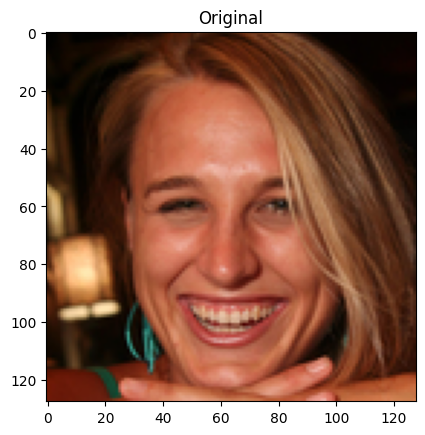

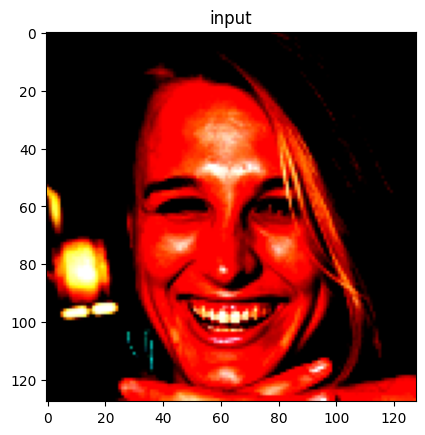

MSE:  tensor 0.070


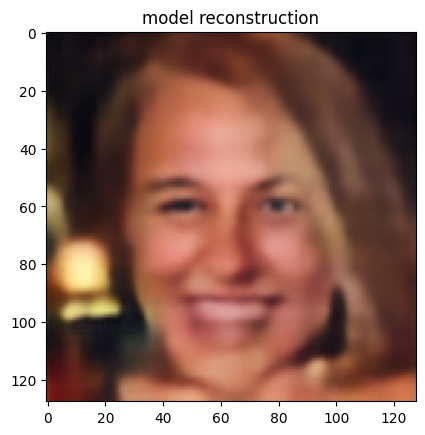

torch.Size([3, 128, 128])


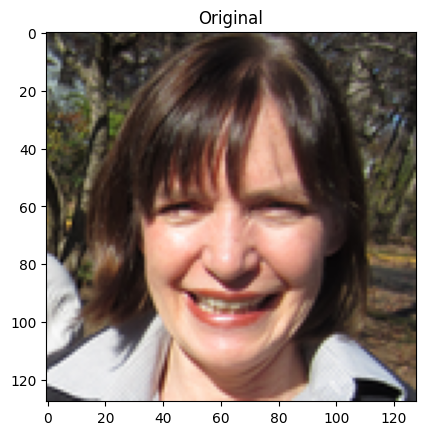

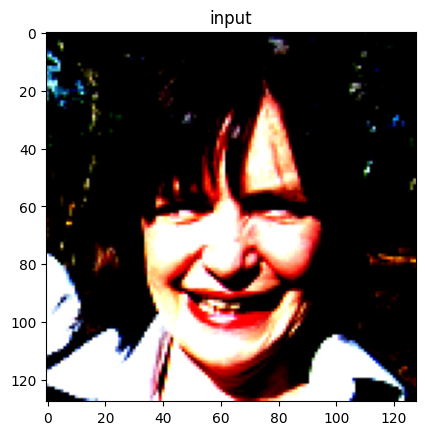

MSE:  tensor 0.121


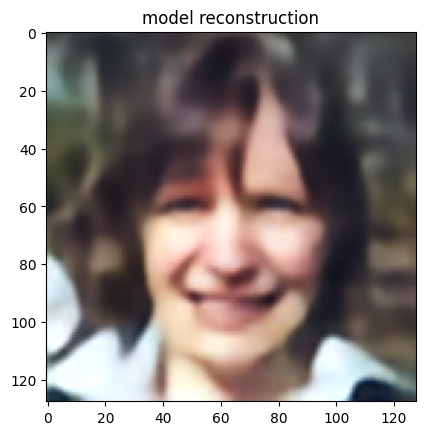

torch.Size([3, 128, 128])


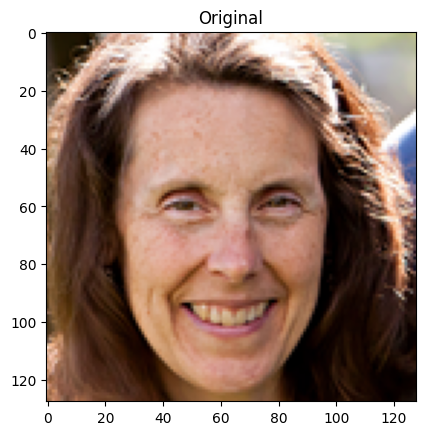

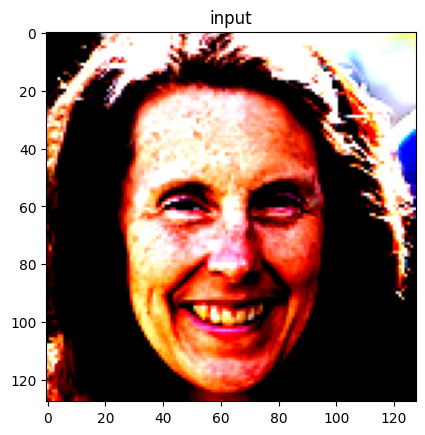

MSE:  tensor 0.123


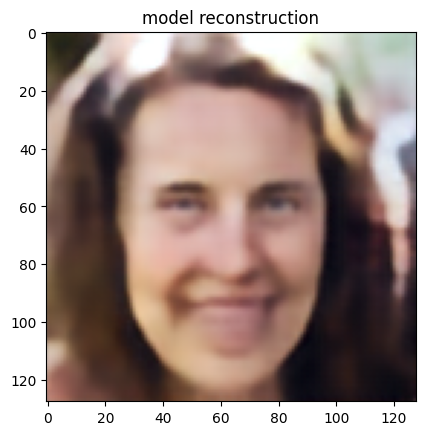

torch.Size([3, 128, 128])


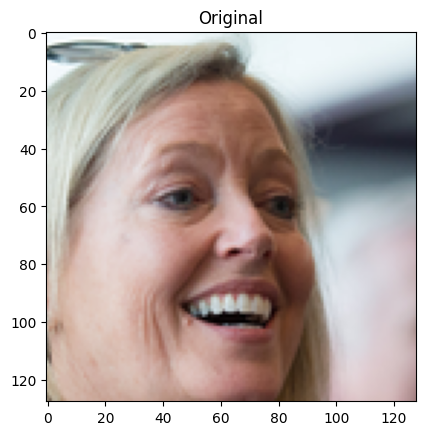

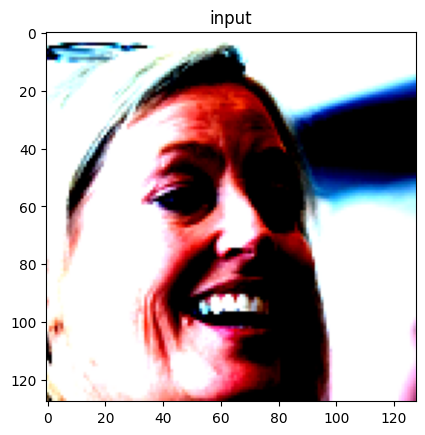

MSE:  tensor 0.055


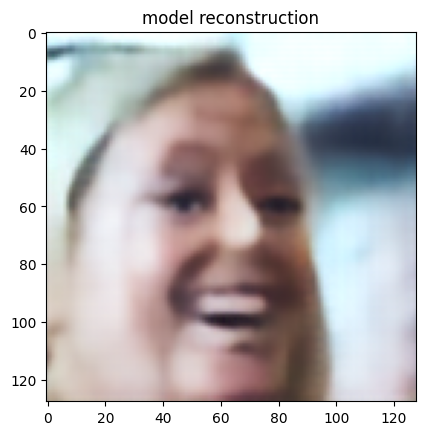

torch.Size([3, 128, 128])


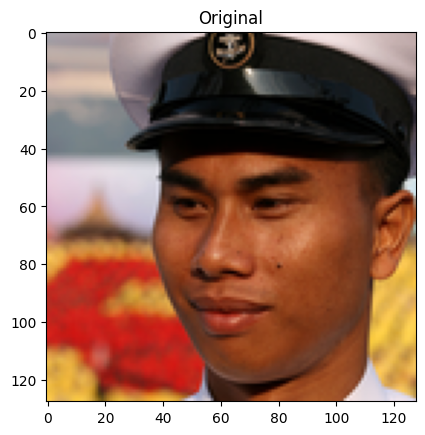

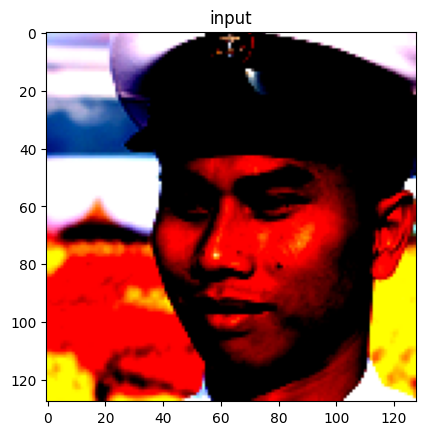

MSE:  tensor 0.081


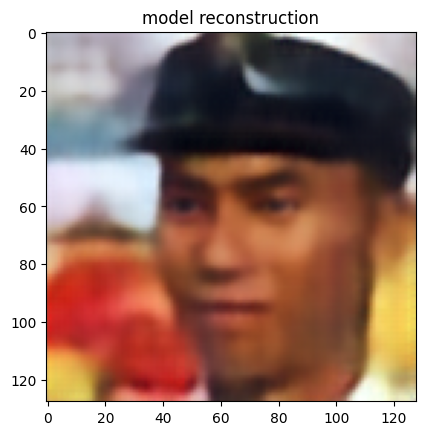

torch.Size([3, 128, 128])


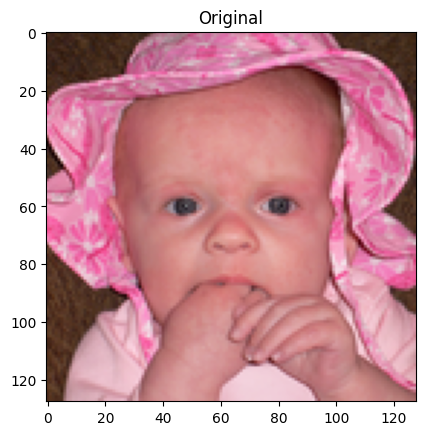

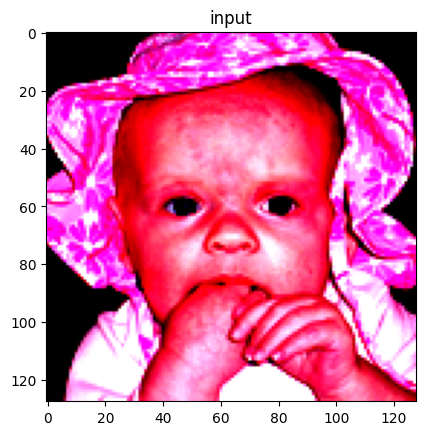

MSE:  tensor 0.105


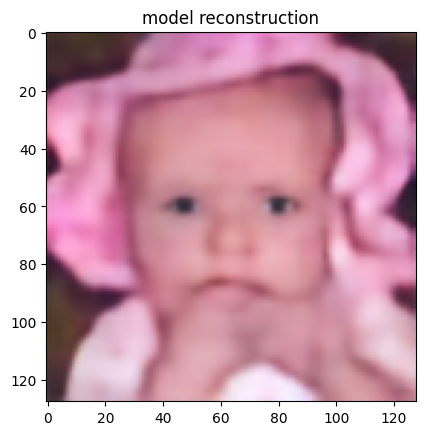

torch.Size([3, 367, 352])


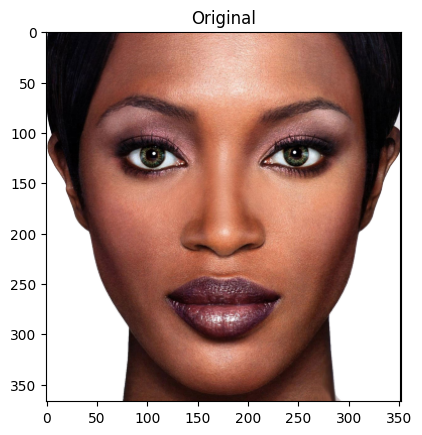

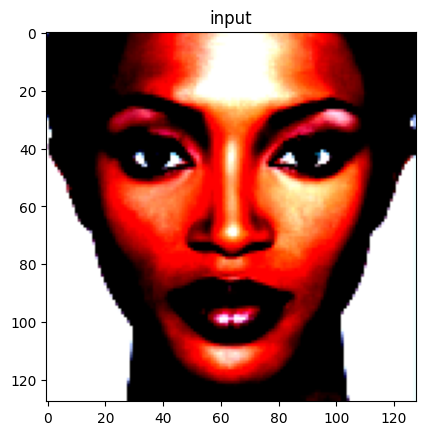

MSE:  tensor 0.070


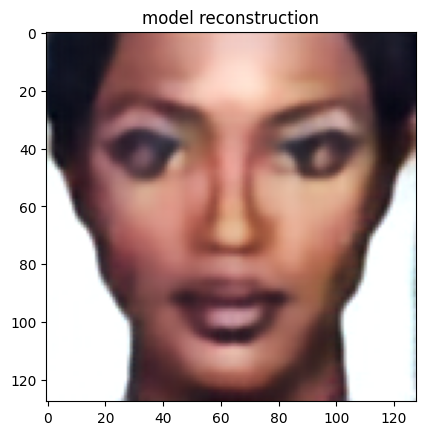

torch.Size([3, 236, 230])


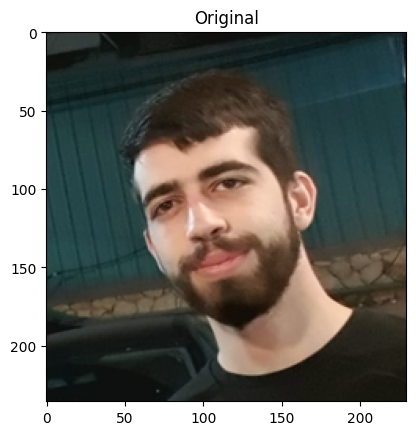

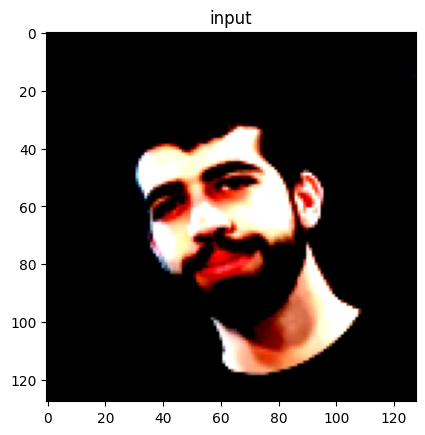

MSE:  tensor 0.042


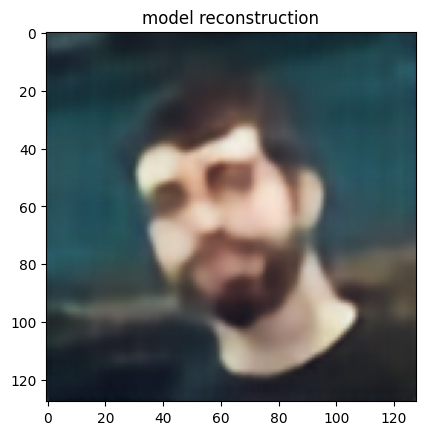

In [ ]:
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor()  # Convert to tensor
# ])

# val_transform = transforms.Compose([
#     transforms.Resize((128, 128)),  # Resize first (order matters)
#     transforms.ToTensor(),  # Convert to tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

# transform = val_transform

# # mfn_denormalize = lambda im: ((im*128) + 127.5)
# reg_denorm = lambda im: torch.clamp(unnormalize(im, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 0, 1)
# recon_images(model, denormalize=reg_denorm)
# reconstruct_image(model, "/kaggle/input/l2dasdas/l2.png", denormalize=reg_denorm)
# reconstruct_image(model, "/kaggle/input/my-pic/my_pic.png", denormalize=reg_denorm)